### TUTORIAL

In [1]:
import pandas as pd
import numpy as np
import csv
from sklearn.utils import Bunch
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from gensim.models import Word2Vec
import nltk
from gensim.models import KeyedVectors

from nltk.cluster import KMeansClusterer
from nltk.tokenize import word_tokenize
#nltk.download('punkt')
import numpy as np 

from sklearn import cluster
from sklearn import metrics

from tensorflow.keras.preprocessing.text import one_hot
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [2]:
    categories = ["not_sexist", "sexist"]
    #               2161           989

In [3]:
data = pd.read_csv("my_csv.csv",sep = ',')
data.columns = ['tweet', 'class']

X = data['tweet']
y = data['class']

X_train, X_test, y_train , y_test = train_test_split(X , y ,test_size=0.3)

### Tokenizing text with scikit-learn

In [4]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(2204, 11305)

In [5]:
count_vect.vocabulary_.get(u'femme')

4027

### From occurrences to frequencies

In [6]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(2204, 11305)

### Training a classifier

In [7]:
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [8]:
docs_new = ["Les hommes c'est tous les mêmes", 'Il est étudiant.'] #marche pas du tout
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
     print('%r => %s' % (doc, categories[category]))

"Les hommes c'est tous les mêmes" => not_sexist
'Il est étudiant.' => not_sexist


### Building a pipeline

In [9]:
text_clf = Pipeline([
...     ('vect', CountVectorizer()),
...     ('tfidf', TfidfTransformer()),
...     ('clf', MultinomialNB()),
... ])
text_clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

### Evaluation of the performance on the test set

In [10]:
docs_test = X_test
predicted = text_clf.predict(docs_test)
np.mean(predicted == y_test)

0.6846560846560846

### SVM

In [11]:
text_clf = Pipeline([
...     ('vect', CountVectorizer()),
...     ('tfidf', TfidfTransformer()),
...     ('clf', SGDClassifier(loss='hinge', penalty='l2',
...                           alpha=1e-3, random_state=42,
...                           max_iter=5, tol=None)),
... ])
text_clf.fit(X_train, y_train)
predicted = text_clf.predict(docs_test)
np.mean(predicted == y_test)

0.7534391534391535

In [12]:
print(metrics.classification_report(y_test, predicted,
...     target_names=categories))

              precision    recall  f1-score   support

  not_sexist       0.75      0.94      0.84       637
      sexist       0.76      0.36      0.49       308

    accuracy                           0.75       945
   macro avg       0.75      0.65      0.66       945
weighted avg       0.75      0.75      0.72       945



In [13]:
metrics.confusion_matrix(y_test, predicted)

array([[601,  36],
       [197, 111]], dtype=int64)

### Parameter tuning using grid search

In [14]:
parameters = {
...     'vect__ngram_range': [(1, 1), (1, 2)],
...     'tfidf__use_idf': (True, False),
...     'clf__alpha': (1e-2, 1e-3),
... }

In [15]:
gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)

In [16]:
gs_clf = gs_clf.fit(X_train[:100], y_train[:100])
#ameliorer vecteur et algo et representation
#-> plus de poids sur les mots sexistes

In [17]:
example_1 = 'La femme'
example_2 = "L'homme"
example_3 = "La femme doit être dans la cuisine"

print(example_1 + "  => " + str(categories[gs_clf.predict([example_1])[0]]))
print(example_2 + "  => " + str(categories[gs_clf.predict([example_2])[0]]))
print(example_3 + "  => " + str(categories[gs_clf.predict([example_3])[0]]))

La femme  => not_sexist
L'homme  => sexist
La femme doit être dans la cuisine  => not_sexist


In [18]:
gs_clf.best_score_

0.78

In [19]:
for param_name in sorted(parameters.keys()):
     print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__alpha: 0.001
tfidf__use_idf: False
vect__ngram_range: (1, 1)


### Oversampling

In [20]:
# instantiating the random over sampler 
ros = RandomOverSampler()
# resampling X, y
X_ros, y_ros = ros.fit_resample(np.array(X_train).reshape(-1,1), y_train)# new class distribution 
print(Counter(y_ros))

Counter({1: 1523, 0: 1523})


In [21]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_ros.ravel())
X_train_counts.shape

(3046, 11305)

In [22]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(3046, 11305)

In [23]:
clf = MultinomialNB().fit(X_train_tfidf, y_ros)
docs_new = ["y'a que les femmes qui pleurent", "C'est un homme."] 
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
     print('%r => %s' % (doc, categories[category]))
        
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB()),])
text_clf.fit(X_ros.ravel(), y_ros)


# resampling X, y
X_ros_test, y_ros_test = ros.fit_resample(np.array(X_test).reshape(-1,1), y_test)# new class distribution 
docs_test = X_ros_test.ravel()
predicted = text_clf.predict(docs_test)
np.mean(predicted == y_ros_test)
print("Accuracy : ", np.mean(predicted == y_ros_test))
metrics.confusion_matrix(y_ros_test, predicted)

"y'a que les femmes qui pleurent" => sexist
"C'est un homme." => sexist
Accuracy :  0.7613814756671899


array([[440, 197],
       [107, 530]], dtype=int64)

### Undersampling

In [24]:
# instantiating the random over sampler 
ros = RandomUnderSampler()
# resampling X, y
X_ros, y_ros = ros.fit_resample(np.array(X_train).reshape(-1,1), y_train)# new class distribution 
print(Counter(y_ros))

Counter({0: 681, 1: 681})


In [25]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_ros.ravel())
X_train_counts.shape

(1362, 7950)

In [26]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(1362, 7950)

In [27]:
clf = MultinomialNB().fit(X_train_tfidf, y_ros)
docs_new = ["y'a que les femmes qui pleurent", "C'est un homme."] 
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
     print('%r => %s' % (doc, categories[category]))
        
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB()),])
text_clf.fit(X_ros.ravel(), y_ros)


# resampling X, y
X_ros_test, y_ros_test = ros.fit_resample(np.array(X_test).reshape(-1,1), y_test)# new class distribution 
docs_test = X_ros_test.ravel()
predicted = text_clf.predict(docs_test)
print("Accuracy : ", np.mean(predicted == y_ros_test))
metrics.confusion_matrix(y_ros_test, predicted)


"y'a que les femmes qui pleurent" => sexist
"C'est un homme." => sexist
Accuracy :  0.7597402597402597


array([[206, 102],
       [ 46, 262]], dtype=int64)

### Oversampling and Undersampling

In [28]:
over = RandomOverSampler(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.8)

In [29]:
X_over, y_over = over.fit_resample(np.array(X_train).reshape(-1,1), y_train)
print(f"Oversampled: {Counter(y_over)}")

Oversampled: Counter({0: 1523, 1: 761})


In [30]:
# now to comine under sampling 
X_ros, y_ros = under.fit_resample(X_over, y_over)
print(f"Combined Random Sampling: {Counter(y_ros)}")

Combined Random Sampling: Counter({0: 951, 1: 761})


In [31]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_ros.ravel())
X_train_counts.shape

(1712, 9137)

In [32]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(1712, 9137)

In [33]:
clf = MultinomialNB().fit(X_train_tfidf, y_ros)
docs_new = ["y'a que les femmes qui pleurent", "C'est un homme."]
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
     print('%r => %s' % (doc, categories[category]))
        
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB()),])
text_clf.fit(X_ros.ravel(), y_ros)


# resampling X, y
X_ros_test, y_ros_test = ros.fit_resample(np.array(X_test).reshape(-1,1), y_test)# new class distribution 
docs_test = X_ros_test.ravel()
predicted = text_clf.predict(docs_test)
print("Accuracy : ", np.mean(predicted == y_ros_test))
metrics.confusion_matrix(y_ros_test, predicted)


"y'a que les femmes qui pleurent" => sexist
"C'est un homme." => sexist
Accuracy :  0.698051948051948


array([[238,  70],
       [116, 192]], dtype=int64)

### Word Embedding using Doc2Vec

###### 1st Step : Getting cleaned data

In [34]:
data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class']
    

X = data['tweet']
y = data['class'] 

X_train, X_test, y_train , y_test = train_test_split(X , y ,test_size=0.3)

###### 2nd step : Keeping a tokenized version of the sentences and the corresponding categories

In [35]:
X_tokenized = []
y_tokenized = []

for sentence in X_train:
    X_tokenized.append(word_tokenize(sentence))    
    
for cat in y_train:
    y_tokenized.append(cat)

###### 3rd step : Defining a cosine function to compute the similaity between two vectors

In [36]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

###### 4th step : Building a tagged sentence corpus

In [37]:
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(X_tokenized)]
tagged_data

[TaggedDocument(words=['événement', 'réputation', 'time', '2017', 'du', 'tweet', 'balancetonporc', 'couverture', 'du', 'elle', 'anatomie', 'dune', 'levée', 'de', 'boucliers', 'généralisée', 'avec', 'annatwit', 'reptime2017', 'en', 'savoir', 'plus', 'gt', 'programme', 'inscription', 'gt'], tags=[0]),
 TaggedDocument(words=['il', 'y', 'cinq', 'mois', 'hashtag', 'balancetonporc', 'apparaissait', 'sur', 'twitter', 'linitiative', 'de', 'journaliste', 'sandra', 'muller', 'elle', 'sera', 'suivie', 'par', '216', '759', 'autres', 'anonymes', 'ou', 'non…', 'franceinfo', 'recueilli', 'témoignages', 'de', 'quelques', 'unes', 'dentre', 'elles', 'lettreaudio'], tags=[1]),
 TaggedDocument(words=['lironie', 'au', 'cœur', 'dune', 'repentance', 'sur', 'lesclavage', 'noirs', 'femme', 'noire', 'permet', 'lexaltation', 'de', 'lesclavage', 'femmes', 'gpa'], tags=[2]),
 TaggedDocument(words=['toulouse', 'hôpital', 'purpan', 'internes', 'dénoncent', 'harcèlementsexuel', 'dans', 'lettre', 'ouverte', 'sexisme',

###### 5th step : train the model

In [38]:
model = Doc2Vec(tagged_data, vector_size = 20, window = 2, min_count = 1, epochs = 100)

###### 6th step : testing the model

In [39]:
def predicted_category(sentence):
    sentence = sentence.lower()
    test_doc = word_tokenize(sentence)
    test_doc_vector = model.infer_vector(test_doc)
    similar_sentences = model.docvecs.most_similar(positive = [test_doc_vector]) 
    similar_senetences_categories = [y_tokenized[similar_sentences[i][0]] for i in range(len(similar_sentences))]

    nb_0 = similar_senetences_categories.count(0)
    nb_1 = similar_senetences_categories.count(1)
    
    if(nb_0 <= nb_1):
        return 1
    
    else:
        return 0

    
predictions = []    
for sentence in X_test:
    predictions.append(predicted_category(sentence))
  
print("Accuracy : ", np.mean(predictions == y_test))
metrics.confusion_matrix(y_test, predictions)

<ipython-input-39-8751669f327c>:5: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  similar_sentences = model.docvecs.most_similar(positive = [test_doc_vector])


Accuracy :  0.6857142857142857


array([[517, 129],
       [168, 131]], dtype=int64)

### Word Embedding using tensorflow keras

In [40]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [41]:
data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class']
    

sentences = list(data['tweet'])
labels = [categories[i] for i in data['class']]

print(labels)

['not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_

In [42]:
#splitting dataset
train_size = int(len(sentences) * training_portion)
train_sentences = sentences[:train_size] #X_train
train_labels = labels[:train_size] #y_train
validation_sentences = sentences[train_size:] #X_test

validation_labels = labels[train_size:] #y_test
print(train_labels)

['not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_

In [43]:
#tokenizing sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)

In [44]:
word_index = tokenizer.word_index
total_words = len(word_index)+1 #1 for oov word
print(total_words)
print(word_index)

11241
{'<OOV>': 1, 'de': 2, 'pour': 3, 'balancetonporc': 4, 'du': 5, 'qui': 6, 'pas': 7, 'sur': 8, 'dans': 9, 'est': 10, 'sexisme': 11, 'moiaussi': 12, 'femme': 13, 'cest': 14, 'au': 15, 'ce': 16, 'avec': 17, 'ne': 18, 'par': 19, 'on': 20, 'femmes': 21, 'plus': 22, 'le': 23, 'la': 24, 'il': 25, 'metoo': 26, 'contre': 27, 'vous': 28, 'merkel': 29, 'les': 30, 'ça': 31, 'mais': 32, 'fait': 33, 'via': 34, 'comme': 35, 'nous': 36, 'angela': 37, 'aux': 38, 'sont': 39, 'je': 40, 'cette': 41, 'ou': 42, 'si': 43, 'tout': 44, 'sexiste': 45, 'elle': 46, 'monde': 47, 'ensemblecontrelesexisme': 48, 'ont': 49, 'après': 50, 'bleues': 51, 'mouvement': 52, 'ironie': 53, 'viol': 54, 'faire': 55, 'bien': 56, 'etmaintenant': 57, 'et': 58, 'leur': 59, 'quand': 60, 'y': 61, 'france': 62, 'même': 63, 'aussi': 64, 'jai': 65, 'royal': 66, 'journée': 67, 'harcèlement': 68, 'suis': 69, 'match': 70, 'macron': 71, 'être': 72, 'ségolène': 73, 'merci': 74, 'en': 75, 'hommes': 76, 'me': 77, 'été': 78, 'une': 79, 'tou

In [45]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)



NameError: name 'validation_sequences' is not defined

In [ ]:
print(len(train_sentences[1]))
print(len(train_sequences[1]))
print(len(train_padded[1]))
print()
print(train_sentences[1])
print(train_sequences[1])
print(train_padded[1])

In [ ]:
#tokenizing labels
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [ ]:
print(training_label_seq)
print(training_label_seq.shape)
print(type(training_label_seq[0]))


In [ ]:
#creating model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

In [ ]:
num_epochs = 30
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_label_seq), 
                    verbose=2)

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
#visualizing embedded words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

In [ ]:
import io
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

#use tensorflow embedding projector to visualize results by uploading this vector and metadata

### TEST 

In [46]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [47]:
data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class']
    

X = data['tweet']
y = data['class'] 


categories = ["NotSexist", "Sexist"]

X_train, X_test, y_train , y_test = train_test_split(X , y ,test_size=0.3)

X = list(X)
y = [categories[i] for i in y]
X_train = list(X_train)
X_test = list(X_test)
y_train = [categories[i] for i in y_train]
y_test = [categories[i] for i in y_test]
print(y_train)

['NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'Sexist', 'NotSexist', 'Sexist', 'Sexist', 'Sexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'Sexist', 'Sexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexis

In [48]:
#tokenizing sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

In [49]:
word_index = tokenizer.word_index
total_words = len(word_index)+1 #1 for oov word
print(total_words)
print(word_index)

10536
{'<OOV>': 1, 'de': 2, 'balancetonporc': 3, 'pour': 4, 'pas': 5, 'du': 6, 'qui': 7, 'est': 8, 'femme': 9, 'sur': 10, 'dans': 11, 'cest': 12, 'sexisme': 13, 'ne': 14, 'au': 15, 'ce': 16, 'on': 17, 'moiaussi': 18, 'avec': 19, 'il': 20, 'par': 21, 'femmes': 22, 'plus': 23, 'vous': 24, 'le': 25, 'ça': 26, 'metoo': 27, 'la': 28, 'mais': 29, 'contre': 30, 'fait': 31, 'si': 32, 'les': 33, 'comme': 34, 'elle': 35, 'sexiste': 36, 'merkel': 37, 'cette': 38, 'faire': 39, 'je': 40, 'nous': 41, 'aux': 42, 'tout': 43, 'sont': 44, 'via': 45, 'ou': 46, 'viol': 47, 'angela': 48, 'et': 49, 'bien': 50, 'ont': 51, 'quand': 52, 'même': 53, 'jai': 54, 'leur': 55, 'ensemblecontrelesexisme': 56, 'me': 57, 'après': 58, 'monde': 59, 'ironie': 60, 'aussi': 61, 'y': 62, 'france': 63, 'suis': 64, 'harcèlement': 65, 'mouvement': 66, 'hommes': 67, 'être': 68, 'dune': 69, 'alors': 70, 'etmaintenant': 71, 'en': 72, 'quil': 73, 'travail': 74, 'homme': 75, 'enceinte': 76, 'bleues': 77, 'été': 78, 'un': 79, 'moi': 8

In [50]:
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(X_test)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)


In [51]:
#tokenizing labels
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(y_train))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(y_test))



In [52]:
#creating model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           16000     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 6)                 150       
                                                                 
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


In [53]:
num_epochs = 30
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_label_seq), 
                    verbose=2)

Epoch 1/30
69/69 - 1s - loss: 1.6309 - accuracy: 0.6405 - val_loss: 1.3993 - val_accuracy: 0.6921 - 1s/epoch - 17ms/step
Epoch 2/30
69/69 - 0s - loss: 1.0826 - accuracy: 0.6832 - val_loss: 0.7921 - val_accuracy: 0.6921 - 281ms/epoch - 4ms/step
Epoch 3/30
69/69 - 0s - loss: 0.7149 - accuracy: 0.6832 - val_loss: 0.6536 - val_accuracy: 0.6921 - 184ms/epoch - 3ms/step
Epoch 4/30
69/69 - 0s - loss: 0.6456 - accuracy: 0.6832 - val_loss: 0.6269 - val_accuracy: 0.6921 - 227ms/epoch - 3ms/step
Epoch 5/30
69/69 - 0s - loss: 0.6296 - accuracy: 0.6832 - val_loss: 0.6190 - val_accuracy: 0.6921 - 262ms/epoch - 4ms/step
Epoch 6/30
69/69 - 0s - loss: 0.6216 - accuracy: 0.6832 - val_loss: 0.6124 - val_accuracy: 0.6921 - 162ms/epoch - 2ms/step
Epoch 7/30
69/69 - 0s - loss: 0.6163 - accuracy: 0.6832 - val_loss: 0.6075 - val_accuracy: 0.6921 - 270ms/epoch - 4ms/step
Epoch 8/30
69/69 - 0s - loss: 0.6108 - accuracy: 0.6832 - val_loss: 0.6027 - val_accuracy: 0.6921 - 161ms/epoch - 2ms/step
Epoch 9/30
69/69 -

In [54]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

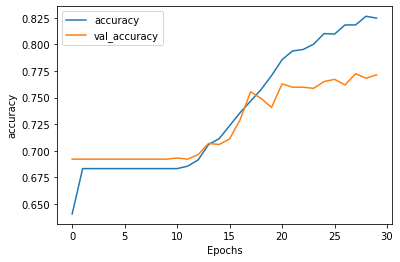

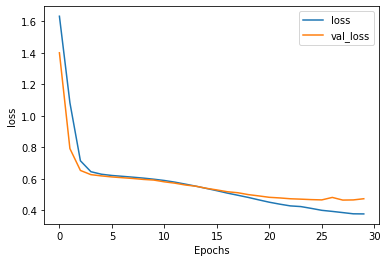

In [55]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [56]:
#visualizing embedded words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [57]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(1000, 16)


In [58]:
import io
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

#use tensorflow embedding projector to visualize results by uploading this vector and metadata

In [59]:
y_pred = model.predict(validation_padded)
#print(validation_padded.shape)
print(validation_label_seq.shape)
print(y_pred.shape)

#print(y_pred)
print(y_pred)
#confusion_matrix = tf.math.confusion_matrix(labels=validation_label_seq, predictions=y_pred)


(945, 1)
(945, 6)
[[6.4707710e-05 8.4051323e-01 1.5929005e-01 5.2056126e-05 2.4775627e-05
  5.5046974e-05]
 [5.1632229e-05 8.2018846e-01 1.7965594e-01 4.0508708e-05 1.8971408e-05
  4.4485998e-05]
 [2.7486256e-05 1.3474162e-01 8.6517608e-01 1.5895024e-05 8.5822003e-06
  3.0284982e-05]
 ...
 [6.2845887e-05 8.7123919e-01 1.2856929e-01 5.1697538e-05 2.4487634e-05
  5.2458650e-05]
 [4.9101502e-05 8.7904328e-01 1.2080792e-01 4.0276020e-05 1.8562612e-05
  4.0851326e-05]
 [2.5168094e-05 9.7984481e-01 2.0077135e-02 2.4369290e-05 1.0328984e-05
  1.8206312e-05]]


### Adding weight to the sexist words using tf-idf 

In [60]:
import re

stereotype_liste = []

with open('stereotype_liste.txt',encoding='utf8') as f:
    stereotype_liste = f.readlines()
  


weighted_words = [re.sub(r"\n",'',i) for i in stereotype_liste]


print(weighted_words)


['femme', 'fille', 'nana', 'meuf', 'chienne', 'poule', 'garce', 'femelle', 'princesse', 'chose', 'fillette', 'femme objet', 'femme-objet', 'objet', 'ruminante', 'bonne femme', 'potiche', 'biche', 'cocotte', 'journaleuse', 'sex symbol', 'sex symbole', 'daronne', 'diablesse', 'macrelle', 'gonzesse', 'miss', 'femme parfaite', 'dinde', 'feumeu', 'sainte', 'beurette', 'hardeuse', 'dame', 'madame', 'petite dame', 'vraie femme', 'pauvre femme', 'lesbienne ', 'conne', 'connasse', 'cageot', 'casse-bonbon', 'casse-couille', 'casse-couilles', 'chiennasse', 'chienne', 'emmerdeuse', 'folle', 'garage à bite', 'garce', 'gouine', 'gourdasse', 'gourde', 'morue', 'pétasse', 'pouf', 'pouffiasse', 'poufiasse', 'pute', 'salope', 'sorcière', 'traînée', 'vipère', 'bonne', 'petite', 'moche', 'vieille', 'bombe', 'poitrine', 'sein', 'fesses', 'cul', 'grosse', 'vache', 'truie', 'boudin', 'jupe', 'minijupe ', 'mini-jupe', 'robe', 'décolleté', 'cuisses', 'sexy', 'chatte', 'maquillage', 'baleine', 'belle', 'coquett

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
   
data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class']
    

X = data['tweet']
y = data['class'] 


categories = ["NotSexist", "Sexist"]

vectorizer = TfidfVectorizer()
new_X = vectorizer.fit_transform(X)
vectorizer.get_feature_names_out()


array(['000', '02', '04', ..., 'œuvrer', 'œuvres', 'بادمافاتيسئللمسلمين'],
      dtype=object)

### Naive Bayes classifier

In [62]:
from sklearn.feature_extraction.text import CountVectorizer

data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class']
    

X = data['tweet']
y = data['class'] 


categories = ["NotSexist", "Sexist"]

X_0 = []
X_1 = []
for i in range(len(data)):
    if data['class'][i]==0:
        X_0.append(data['tweet'][i])
        
for i in range(len(data)):
    if data['class'][i]==1:
        X_1.append(data['tweet'][i])



vec_0 = CountVectorizer()
X_c0 = vec_0.fit_transform(X_0)
tdm_0 = pd.DataFrame(X_c0.toarray(), columns=vec_0.get_feature_names())


vec_1 = CountVectorizer()
X_c1 = vec_1.fit_transform(X_1)
tdm_1 = pd.DataFrame(X_c1.toarray(), columns=vec_1.get_feature_names())

tdm_1


C:\Users\evara\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,02,04,06,10,100,1000,102,12,120,12000,...,éviter,évoluent,évoluer,évoquer,êtes,être,êtres,êtreunefemme,ģarrido,بادمافاتيسئللمسلمين
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
985,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
986,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
987,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
word_list_0 = vec_0.get_feature_names();    
count_list_0 = X_c0.toarray().sum(axis=0) 
freq_0 = dict(zip(word_list_0,count_list_0))
freq_0

C:\Users\evara\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


{'000': 4,
 '04': 1,
 '05': 1,
 '10': 7,
 '100': 10,
 '1000': 1,
 '102': 2,
 '10h': 2,
 '10h00': 1,
 '10h30': 1,
 '11': 3,
 '1100': 1,
 '11000': 1,
 '117': 1,
 '12': 8,
 '1200': 1,
 '12000': 1,
 '120battementsparminute': 1,
 '1215': 1,
 '12h': 1,
 '12joursdaction': 1,
 '13': 7,
 '13h50': 1,
 '14': 9,
 '14h': 1,
 '14h00': 1,
 '14h15': 2,
 '14ème': 1,
 '15': 11,
 '157garlamd': 1,
 '15min': 1,
 '15x': 1,
 '16': 4,
 '169': 1,
 '16days': 2,
 '16h': 3,
 '16jours': 3,
 '17': 7,
 '1700': 1,
 '1703': 1,
 '1730': 1,
 '18': 9,
 '180': 1,
 '18006675005': 1,
 '18006686868': 1,
 '1825': 1,
 '18711955': 1,
 '18h': 2,
 '18h00': 1,
 '18h30': 1,
 '18h55': 1,
 '19': 6,
 '1900': 1,
 '1904': 1,
 '1905': 1,
 '1920': 2,
 '1927': 2,
 '1929': 2,
 '195': 2,
 '1954': 1,
 '1962': 1,
 '1965': 1,
 '1970': 1,
 '1979': 1,
 '1986': 1,
 '1987': 1,
 '1992': 1,
 '1999': 1,
 '19e': 1,
 '19h': 1,
 '19h30': 1,
 '19hruthelkrief': 2,
 '1a0maiscpasperdu': 1,
 '1dexmab': 1,
 '1dexmag': 1,
 '1e': 1,
 '1er': 10,
 '1ere': 5,
 '1ir

In [64]:
word_list_1 = vec_1.get_feature_names();    
count_list_1 = X_c1.toarray().sum(axis=0) 
freq_1 = dict(zip(word_list_1,count_list_1))
freq_1

{'02': 3,
 '04': 3,
 '06': 1,
 '10': 6,
 '100': 2,
 '1000': 1,
 '102': 1,
 '12': 5,
 '120': 2,
 '12000': 1,
 '12f': 1,
 '13': 4,
 '14': 3,
 '14amp15': 1,
 '14ans': 1,
 '15': 2,
 '150': 1,
 '15ans': 1,
 '16': 2,
 '16ans': 1,
 '16days': 2,
 '16jours': 3,
 '17': 1,
 '1964': 1,
 '1990': 1,
 '1992': 2,
 '1997': 2,
 '1998': 1,
 '1999': 1,
 '1cm': 1,
 '1dexmag': 1,
 '1er': 1,
 '1ere': 1,
 '1ère': 2,
 '20': 7,
 '2004': 1,
 '2005': 1,
 '2006': 1,
 '2011': 1,
 '20122017': 1,
 '2014': 1,
 '2015': 2,
 '2016': 2,
 '2017': 9,
 '2018': 15,
 '20ans': 1,
 '20hfrance2': 1,
 '20minutes': 2,
 '21': 2,
 '21ème': 2,
 '22': 4,
 '23': 1,
 '24': 1,
 '2499': 1,
 '24hpujadas': 1,
 '25': 2,
 '25janvier': 2,
 '26': 1,
 '26caroll': 1,
 '27': 2,
 '28': 1,
 '2choses': 1,
 '2h': 1,
 '30': 4,
 '31': 1,
 '32': 1,
 '36': 1,
 '3600x': 1,
 '364': 1,
 '3784e': 1,
 '38': 2,
 '3min': 1,
 '3ème': 1,
 '40': 1,
 '40t': 1,
 '44': 1,
 '44t': 1,
 '4h': 1,
 '4m': 1,
 '50': 5,
 '500': 1,
 '5000': 1,
 '50100500': 1,
 '50euros': 1,
 '5

In [65]:
prob_0 = []
for word,count in zip(word_list_0,count_list_0):
    prob_0.append(count/len(word_list_0))
dict(zip(word_list_0,prob_0))


{'000': 0.0004100041000410004,
 '04': 0.0001025010250102501,
 '05': 0.0001025010250102501,
 '10': 0.0007175071750717508,
 '100': 0.001025010250102501,
 '1000': 0.0001025010250102501,
 '102': 0.0002050020500205002,
 '10h': 0.0002050020500205002,
 '10h00': 0.0001025010250102501,
 '10h30': 0.0001025010250102501,
 '11': 0.0003075030750307503,
 '1100': 0.0001025010250102501,
 '11000': 0.0001025010250102501,
 '117': 0.0001025010250102501,
 '12': 0.0008200082000820008,
 '1200': 0.0001025010250102501,
 '12000': 0.0001025010250102501,
 '120battementsparminute': 0.0001025010250102501,
 '1215': 0.0001025010250102501,
 '12h': 0.0001025010250102501,
 '12joursdaction': 0.0001025010250102501,
 '13': 0.0007175071750717508,
 '13h50': 0.0001025010250102501,
 '14': 0.0009225092250922509,
 '14h': 0.0001025010250102501,
 '14h00': 0.0001025010250102501,
 '14h15': 0.0002050020500205002,
 '14ème': 0.0001025010250102501,
 '15': 0.001127511275112751,
 '157garlamd': 0.0001025010250102501,
 '15min': 0.00010250102

In [66]:
prob_1 = []
for word,count in zip(word_list_1,count_list_1):
    prob_1.append(count/len(word_list_1))
dict(zip(word_list_1,prob_1))


{'02': 0.0005072708826513358,
 '04': 0.0005072708826513358,
 '06': 0.00016909029421711193,
 '10': 0.0010145417653026716,
 '100': 0.00033818058843422386,
 '1000': 0.00016909029421711193,
 '102': 0.00016909029421711193,
 '12': 0.0008454514710855597,
 '120': 0.00033818058843422386,
 '12000': 0.00016909029421711193,
 '12f': 0.00016909029421711193,
 '13': 0.0006763611768684477,
 '14': 0.0005072708826513358,
 '14amp15': 0.00016909029421711193,
 '14ans': 0.00016909029421711193,
 '15': 0.00033818058843422386,
 '150': 0.00016909029421711193,
 '15ans': 0.00016909029421711193,
 '16': 0.00033818058843422386,
 '16ans': 0.00016909029421711193,
 '16days': 0.00033818058843422386,
 '16jours': 0.0005072708826513358,
 '17': 0.00016909029421711193,
 '1964': 0.00016909029421711193,
 '1990': 0.00016909029421711193,
 '1992': 0.00033818058843422386,
 '1997': 0.00033818058843422386,
 '1998': 0.00016909029421711193,
 '1999': 0.00016909029421711193,
 '1cm': 0.00016909029421711193,
 '1dexmag': 0.00016909029421711

In [67]:
from sklearn.feature_extraction.text import CountVectorizer

X_train, X_test, y_train , y_test = train_test_split(X , y ,test_size=0.3)
X_train_0 = []
X_train_1 = []
print(X_train)
print(X_train.index)

index =  X_train.index
for i in index:
    if (y_train[i]==0):
        X_train_0.append(X_train[i])
    else:
        X_train_1.append(X_train[i])
        

        



3109    comment ça sexisme ne sévirait pas quau pmu de...
2408    sous prétexte présidente de commission lois ya...
1506    lesperles drague séduction balancetonporc cest...
1133    balancetonporc responsabilité collective by so...
176          les actus est sorti de presse moiaussi metoo
                              ...                        
2511    manon cest genre de connasse qui ramène lex de...
259     retweeted nils wilcke pauldenton sandra muller...
1944    ah nous voilà donc instruits de lavis de plant...
1070            retrouvez dernier communiqué du groupetf1
2747    weinstein balancetonporc fête est fini tous sa...
Name: tweet, Length: 2203, dtype: object
Int64Index([3109, 2408, 1506, 1133,  176, 1554,   82, 1718,  407, 2773,
            ...
            1930, 1408, 2690, 2663, 2372, 2511,  259, 1944, 1070, 2747],
           dtype='int64', length=2203)


In [70]:
vec_0 = CountVectorizer()
X_vec_0 = vec_0.fit_transform(X_train_0)

total_features0 = len(vec_0.get_feature_names())
total_features0


0.6205924971824183

In [71]:
vec_1 = CountVectorizer()
X_vec_1 = vec_1.fit_transform(X_train_1)

total_features1 = len(vec_1.get_feature_names())
total_features1

proba0 = total_features0 / (total_features0+total_features1)
proba1 = total_features1 / (total_features0+total_features1)

print(proba0)
print(proba1)

0.6205924971824183
0.37940750281758173


In [76]:
total_cnts_features_0 = count_list_0.sum(axis=0)
total_cnts_features_1 = count_list_1.sum(axis=0)

In [77]:
from nltk.tokenize import word_tokenize
new_sentence = 'what is the price of the book'
new_word_list = word_tokenize(new_sentence)

In [78]:
def proba_sentence_class0(sentence):
    new_word_list = word_tokenize(sentence)
    prob_s_with_ls = []
    for word in new_word_list:
        if word in freq_0.keys():
            count = freq_0[word]
        else:
            count = 0
        prob_s_with_ls.append((count + 1)/(total_cnts_features_0 + total_features))
    d = dict(zip(new_word_list,prob_s_with_ls))
    res = 1
    for word in sentence.split():
        res = res * d[word]

    res = res * proba0
    return res
  

In [79]:
def proba_sentence_class1(sentence):
    new_word_list = word_tokenize(sentence)
    prob_s_with_ls = []
    for word in new_word_list:
        if word in freq_1.keys():
            count = freq_1[word]
        else:
            count = 0
        prob_s_with_ls.append((count + 1)/(total_cnts_features_1 + total_features))
    d = dict(zip(new_word_list,prob_s_with_ls))
    res = 1
    for word in sentence.split():
        res = res * d[word]

    res = res * proba1
    return res

print(proba_sentence_class1("what is the price of the book"))

NameError: name 'total_features' is not defined

In [80]:
predictions = []
for i in X_test:
    print(i)
    proba_class0 = proba_sentence_class0(i)
    proba_class1 = proba_sentence_class1(i)
    if proba_class0 > proba_class1:
        predictions.append(0)
    else:
        predictions.append(1)
        
print(predictions)

par contre rien sur balancetonbabybel tout sur balancetonporc avouez quil y quand même problème dans ce pays vous pensez quoi


NameError: name 'total_features' is not defined

In [81]:
total_labels = len(y_test)
acc = 0
for i in range(len(y_test)):
    if(y_test[y_test.index[i]]==predictions[i]):
        acc = acc + 1
        
acc = acc / total_labels
print("Accuracy :" , acc)
        
metrics.confusion_matrix(y_test, predictions)

IndexError: list index out of range

In [ ]:
# ==> ajouter les poids
# ==> matrice de confusion
# ==> revoir clean
# ==> meler plusieurs methodes
# ==> tester avec des paramètres différents 
# ==> faire un joli fichier